In [59]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import itertools

In [33]:
df_BoT = pd.read_parquet('../data/parquet/netflow/original/NF-BoT-IoT_chunks')
df_ToN = pd.read_parquet('../data/parquet/netflow/original/NF-ToN-IoT_chunks')

df_BoT = df_BoT.sample(frac=1).reset_index(drop=True)
data = pd.concat([df_BoT, df_ToN]).reset_index(drop=True)

data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.drop(columns=['Attack'],inplace = True)
data.rename(columns={"Label": "label"},inplace = True)
label = data.label
data.drop(columns=['label'],inplace = True)
data = pd.concat([data, label], axis=1)

X = data
y = label

l2 = df_BoT.shape[0]
l1 = int(0.9*l2)

#Train dataset
X_train = X[:l1]
y_train = y[:l1]

#Train dataset
X_val = X[l1:l2]
y_val = y[l1:l2]

#Test dataset
X_test = X[l2:]
y_test = y[l2:]

In [34]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [35]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [37]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [38]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [39]:
G = G.to_directed()

In [40]:
G = from_networkx(G,edge_attrs=['h','label'] )

In [41]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [42]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [43]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [44]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [45]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [46]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [47]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [48]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [49]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(G.edata['label'].cpu().numpy()),
#                                                 G.edata['label'].cpu().numpy())

class_weights = class_weight.compute_class_weight(class_weight = "balanced", 
                                                  classes = np.unique(G.edata['label'].cpu().numpy()), 
                                                  y = G.edata['label'].cpu().numpy())

In [50]:
class_weights

array([21.76904474,  0.51175417])

In [51]:
# if th.backends.mps.is_available():
#     mps_device = th.device("mps")
#     x = th.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")


In [52]:
#class_weights = th.FloatTensor(class_weights).cuda()
class_weights = th.FloatTensor(class_weights)#.to(mps_device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [53]:
#G = G.to('cuda:0')
#G.device
#G.to('mps:0')
#G.device

In [54]:
G.ndata['h'].device


device(type='cpu')

In [56]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)#.to(mps_device)#.cuda()
opt = th.optim.Adam(model.parameters())

In [57]:
for epoch in range(1,5500):
    pred = model(G, node_features,edge_features)#.to(mps_device)#.cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc',str(epoch),':', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Training acc: 0.9177396297454834
Training acc: 0.9202651381492615
Training acc: 0.9204216003417969
Training acc: 0.9221185445785522
Training acc: 0.9295404553413391
Training acc: 0.9298264980316162
Training acc: 0.9353931546211243
Training acc: 0.9369827508926392
Training acc: 0.936795711517334
Training acc: 0.9374197125434875
Training acc: 0.9367457032203674
Training acc: 0.9358606934547424
Training acc: 0.9368262887001038
Training acc: 0.9365115165710449
Training acc: 0.9361476898193359
Training acc: 0.9377288818359375
Training acc: 0.9376363158226013
Training acc: 0.9612036943435669
Training acc: 0.9234461188316345
Training acc: 0.9261595010757446
Training acc: 0.9350154399871826
Training acc: 0.9389666318893433
Training acc: 0.9361708164215088
Training acc: 0.9369771480560303
Training acc: 0.9373780488967896
Training acc: 0.9360634088516235
Training acc: 0.9373224973678589
Training acc: 0.9374159574508667
Training acc: 0.9355199933052063
Training acc: 0.936392068862915
Training acc

In [58]:
MODEL_PATH = '../model/nf_bot_ton_iot.pt'
SCALER_PATH = "../model/_scaler_nf_bot_ton_iot.pkl"

In [60]:
import joblib

th.save(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH) 

['../model/_scaler_nf_bot_ton_iot.pkl']

In [82]:
model = th.load(MODEL_PATH)
model.eval()
scaler = joblib.load(SCALER_PATH) 

In [61]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [66]:
G.ndata['h'].shape[2]
X_val = X[l1:l2]

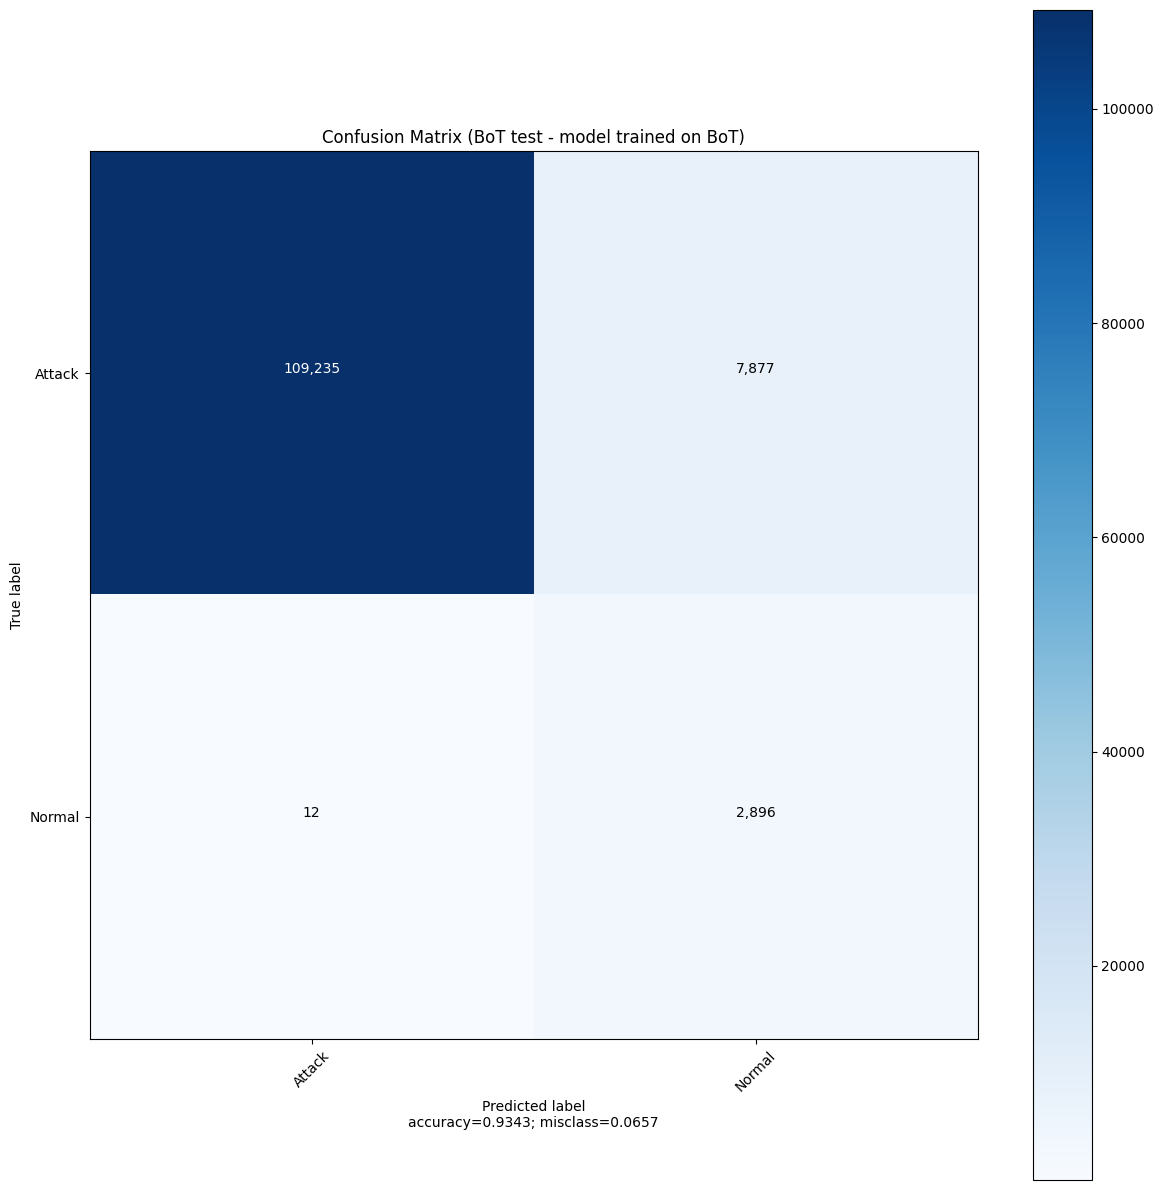

In [67]:
X_val = encoder.transform(X_val)
X_val[cols_to_norm] = scaler.transform(X_val[cols_to_norm])
X_val['h'] = X_val[ cols_to_norm ].values.tolist()

G_val = nx.from_pandas_edgelist(X_val, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_val = G_val.to_directed()
G_val = from_networkx(G_val,edge_attrs=['h','label'] )
actual_val = G_val.edata.pop('label')
G_val.ndata['feature'] = th.ones(G_val.num_nodes(), 8)#G.ndata['h'].shape[2])

G_val.ndata['feature'] = th.reshape(G_val.ndata['feature'], (G_val.ndata['feature'].shape[0], 1, G_val.ndata['feature'].shape[1]))

G_val.edata['h'] = th.reshape(G_val.edata['h'], (G_val.edata['h'].shape[0], 1, G_val.edata['h'].shape[1]))

node_features_val = G_val.ndata['feature']
edge_features_val = G_val.edata['h']
val_pred = model(G_val, node_features_val, edge_features_val)#.cuda()

val_pred = val_pred.argmax(1)
val_pred = th.Tensor.cpu(val_pred).detach().numpy()


actual_val = ["Normal" if i == 0 else "Attack" for i in actual_val]
val_pred = ["Normal" if i == 0 else "Attack" for i in val_pred]

from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual_val, val_pred), 
                      normalize    = False,
                      target_names = np.unique(actual_val),
                      title        = "Confusion Matrix (BoT test - model trained on BoT)")

In [68]:
X_test = encoder.transform(X_test)

In [69]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [70]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [71]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [72]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [73]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [74]:
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test)#.cuda()

In [75]:
test_pred = test_pred.argmax(1)


In [76]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [77]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

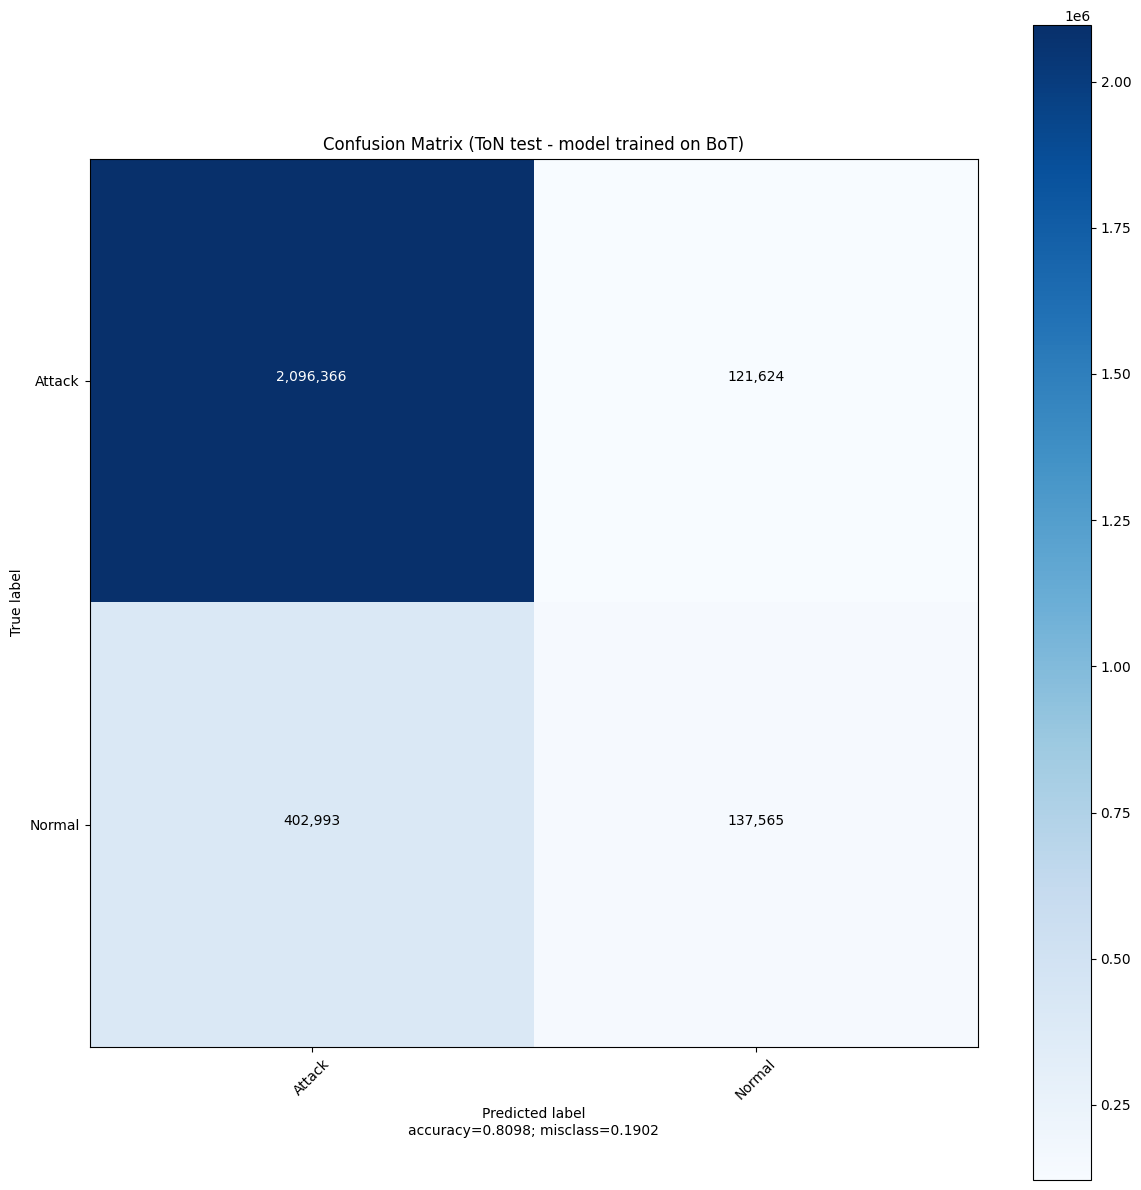

In [78]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix (ToN test - model trained on BoT)")